# Mount to drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/MyDrive/ETH_EEGproject' 
root_path = '/content/gdrive/MyDrive/ETH_EEGproject'

Mounted at /content/gdrive


# Import libraries

In [ ]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, Lambda
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.utils import to_categorical
import numpy as np
from sklearn import preprocessing
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler
from keras.layers.wrappers import TimeDistributed

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
def train_test_split_tensors(X, y, **options):
    """
    encapsulation for the sklearn.model_selection.train_test_split function
    in order to split tensors objects and return tensors as output

    :param X: tensorflow.Tensor object
    :param y: tensorflow.Tensor object
    :dict **options: typical sklearn options are available, such as test_size and train_size
    """

    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(X.numpy(), y.numpy(), **options)

    X_train, X_test = tf.constant(X_train), tf.constant(X_test)
    y_train, y_test = tf.constant(y_train), tf.constant(y_test)

    del(train_test_split)

    return X_train, X_test, y_train, y_test



x = tf.io.read_file("gdrive/MyDrive/ETH_EEGproject/tensor1_99")
X = tf.io.parse_tensor(x, tf.float32, name=None)
#X *= 255
"""
z = tf.io.read_file("gdrive/MyDrive/ETH_EEGproject/tensor60_109")
Z = tf.io.parse_tensor(z, tf.float32, name=None)
Z *= 255
X = tf.concat([X,Z],axis = -1)
"""
X = tf.transpose(X, perm = [3,0,1,2])

"""
labels = pd.read_csv('labels.csv')
le = preprocessing.LabelEncoder()
le.fit(labels[107998:-1])
#y = np.array([])
y = le.transform(labels[107998:-1])
y = y.ravel()
"""

y = np.loadtxt("gdrive/MyDrive/ETH_EEGproject/complete_labels.csv", delimiter=",")
#y = tf.keras.utils.to_categorical(temp[0:104400])
y_train_num = tf.convert_to_tensor(y[0:171000], dtype=np.int64)

#y = to_categorical(y, 3)

x_train, x_test, y_train, y_test = train_test_split_tensors(X, y_train_num, test_size=0.20,shuffle=False)

# down sampling
x_train_res = tf.reshape(x_train, [x_train.shape[0], 32*32*3])
#y_train_num = np.argmax(y_train,axis=1)
rus = RandomUnderSampler(random_state=42)
X_train_down, y_train_down = rus.fit_resample(x_train_res, y_train)

X_train_down = tf.reshape(X_train_down, [X_train_down.shape[0], 32, 32, 3])
y_train_down = keras.utils.to_categorical(y_train_down)
y_test = keras.utils.to_categorical(y_test)

"""
#further split training data for testing
    x_train_true = x_train[0:83500,:,:,:]
y_train_true = y_train[0:8350]

x_new = x_train[83501:83520,:,:,:]
y_new_true = y_train[83501:83520]

#y_train_true = to_categorical(y_train_true, 3)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
"""
# convert class vectors to binary class matrices
#y_train = np_utils.to_categorical(y_train, num_classes)
#y_test = np_utils.to_categorical(y_test, num_classes)
batch_size = 32
num_classes = 3
epochs = 100

input_shape = (32, 32, 3)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
x_test.shape

TensorShape([20880, 32, 32, 3])

# Proposed

In [ ]:
from keras import regularizers
input_shape = (32, 32, 3)

model = Sequential()

model.add(Conv2D(64, (3, 3), activation="relu"))
#model.add(Dropout(0.1))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(Conv2D(64, (3, 3), activation="relu"))

# max pooling
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
#model.add(Dropout(0.25))#

# 2 convolutional 3 x 128
model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(Conv2D(128, (3, 3), activation="relu"))

# max pooling
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
#model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), activation="relu"))
model.add(Conv2D(256, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(TimeDistributed(Flatten()))
model.add(LSTM(256, return_sequences=False))

model.add(Dense(3))
model.add(Activation('softmax'))

opt = keras.optimizers.RMSprop(lr=0.001, decay=1e-6)
optsgd = keras.optimizers.SGD(lr=0.01, momentum=0.9)
optadam = keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam"
)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=optsgd, 
              metrics=['accuracy'])

print("fitting...")

history = model.fit(X_train_down, y_train_down,
          batch_size=16,
          epochs=20)


score = model.evaluate(x_test, y_test, verbose=1)

y_new = model.predict(x_test)

fitting...
Epoch 1/20
6372/6372 [==============================] - 34s 5ms/step - loss: 1.0987 - accuracy: 0.3423
Epoch 2/20
6372/6372 [==============================] - 34s 5ms/step - loss: 1.0945 - accuracy: 0.3616
Epoch 3/20
6372/6372 [==============================] - 34s 5ms/step - loss: 1.0925 - accuracy: 0.3668
Epoch 4/20
6372/6372 [==============================] - 34s 5ms/step - loss: 1.0912 - accuracy: 0.3694
Epoch 5/20
6372/6372 [==============================] - 34s 5ms/step - loss: 1.0900 - accuracy: 0.3746
Epoch 6/20
6372/6372 [==============================] - 34s 5ms/step - loss: 1.0888 - accuracy: 0.3773
Epoch 7/20
6372/6372 [==============================] - 34s 5ms/step - loss: 1.0874 - accuracy: 0.3809
Epoch 8/20
6372/6372 [==============================] - 34s 5ms/step - loss: 1.0857 - accuracy: 0.3836
Epoch 9/20
6372/6372 [==============================] - 34s 5ms/step - loss: 1.0831 - accuracy: 0.3890
Epoch 10/20
6372/6372 [==============================] - 34s 5

# LSTM1

In [ ]:
from keras import regularizers
input_shape = (32, 32, 3)

model = Sequential()

model.add(Conv2D(16, (3, 3), activation="relu"))
#model.add(Dropout(0.1))
model.add(Conv2D(32, (3, 3), activation="relu"))

# max pooling
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.25))#

# 2 convolutional 3 x 128
model.add(Conv2D(64, (3, 3), activation="relu", kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
# max pooling
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
#model.add(Dropout(0.25))

model.add(TimeDistributed(Flatten()))
model.add(LSTM(256, return_sequences=False))
model.add(Dense(100,kernel_regularizer=regularizers.l2(0.001)))
model.add(Activation('relu'))
model.add(BatchNormalization())
#model.add(Dropout(0.5))
#model.add(Lambda(lambda x: tf.expand_dims(model.output, axis=-1)))
model.add(Dense(3))
model.add(Activation('softmax'))

opt = keras.optimizers.RMSprop(lr=0.001, decay=1e-6)
optsgd = keras.optimizers.SGD(lr=0.01, momentum=0.9)
optadam = keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam"
)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=optadam, 
              metrics=['accuracy'])

print("fitting...")

history = model.fit(X_train_down, y_train_down,
          batch_size=32,
          epochs=150)


score = model.evaluate(x_test, y_test, verbose=1)

y_new = model.predict(x_test)

fitting...
Epoch 1/150
3151/3151 [==============================] - 16s 5ms/step - loss: 1.1675 - accuracy: 0.3450
Epoch 2/150
3151/3151 [==============================] - 17s 5ms/step - loss: 1.1044 - accuracy: 0.3542
Epoch 3/150
3151/3151 [==============================] - 16s 5ms/step - loss: 1.1003 - accuracy: 0.3615
Epoch 4/150
3151/3151 [==============================] - 16s 5ms/step - loss: 1.0966 - accuracy: 0.3662
Epoch 5/150
3151/3151 [==============================] - 16s 5ms/step - loss: 1.0951 - accuracy: 0.3666
Epoch 6/150
3151/3151 [==============================] - 16s 5ms/step - loss: 1.0934 - accuracy: 0.3693
Epoch 7/150
3151/3151 [==============================] - 16s 5ms/step - loss: 1.0926 - accuracy: 0.3740
Epoch 8/150
3151/3151 [==============================] - 16s 5ms/step - loss: 1.0911 - accuracy: 0.3743
Epoch 9/150
3151/3151 [==============================] - 16s 5ms/step - loss: 1.0907 - accuracy: 0.3745
Epoch 10/150
3151/3151 [=============================

In [ ]:
score = model.evaluate(x_test, y_test, verbose=1)

y_new = model.predict(x_test)

1069/1069 [==============================] - 3s 3ms/step - loss: 1.3034 - accuracy: 0.3682


In [ ]:
from collections import Counter
Counter(np.argmax(y_new,axis=1))

Counter({0: 14105, 1: 10038, 2: 10057})

dict_keys(['loss', 'accuracy'])


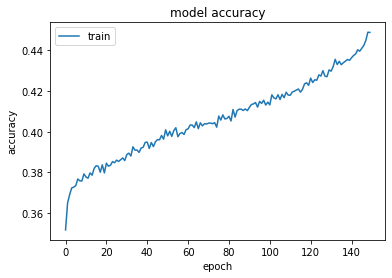

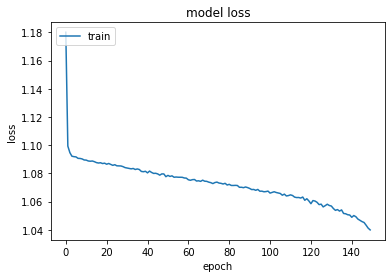

In [ ]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
print(model.summary())

ValueError: ignored

Another location and weight of dropout layer

In [ ]:
from keras import regularizers
input_shape = (32, 32, 3)

model = Sequential()

model.add(Conv2D(16, (3, 3), activation="relu"))
#model.add(Dropout(0.1))
model.add(Conv2D(32, (3, 3), activation="relu"))

# max pooling
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.25))#
model.add(Conv2D(64, (3, 3), activation="relu", kernel_regularizer=regularizers.l2(0.001)))

# max pooling
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.1))

model.add(TimeDistributed(Flatten()))
model.add(LSTM(256, return_sequences=False))
model.add(Dense(100,kernel_regularizer=regularizers.l2(0.001)))
##model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
#model.add(Lambda(lambda x: tf.expand_dims(model.output, axis=-1)))
model.add(Dense(3))
model.add(Activation('softmax'))

opt = keras.optimizers.RMSprop(lr=0.001, decay=1e-6)
optsgd = keras.optimizers.SGD(lr=0.01, momentum=0.9)
optadam = keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam"
)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=optadam, 
              metrics=['accuracy'])

print("fitting...")

history = model.fit(X_train_down, y_train_down,
          batch_size=32,
          epochs=150)


score = model.evaluate(x_test, y_test, verbose=1)

y_new = model.predict(x_test)

fitting...
Epoch 1/150
1944/1944 [==============================] - 11s 6ms/step - loss: 1.1622 - accuracy: 0.3540
Epoch 2/150
1944/1944 [==============================] - 11s 6ms/step - loss: 1.0974 - accuracy: 0.3628
Epoch 3/150
1944/1944 [==============================] - 11s 6ms/step - loss: 1.0932 - accuracy: 0.3702
Epoch 4/150
1944/1944 [==============================] - 11s 6ms/step - loss: 1.0928 - accuracy: 0.3696
Epoch 5/150
1944/1944 [==============================] - 11s 6ms/step - loss: 1.0923 - accuracy: 0.3729
Epoch 6/150
1944/1944 [==============================] - 11s 6ms/step - loss: 1.0911 - accuracy: 0.3731
Epoch 7/150
1944/1944 [==============================] - 11s 6ms/step - loss: 1.0911 - accuracy: 0.3726
Epoch 8/150
1944/1944 [==============================] - 11s 6ms/step - loss: 1.0904 - accuracy: 0.3764
Epoch 9/150
1944/1944 [==============================] - 11s 6ms/step - loss: 1.0905 - accuracy: 0.3744
Epoch 10/150
1944/1944 [=============================

In [ ]:
from collections import Counter
Counter(np.argmax(y_new,axis=1))

Counter({0: 6880, 1: 13996, 2: 4})

The network below overfits (0.8) and returns test score of 0.39 (without dropout in between dense layers)

In [ ]:
from keras import regularizers
input_shape = (32, 32, 3)

model = Sequential()

model.add(Conv2D(16, (3, 3), activation="relu"))
#model.add(Dropout(0.1))
model.add(Conv2D(32, (3, 3), activation="relu"))

# max pooling
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.25))#

# 2 convolutional 3 x 128
model.add(Conv2D(64, (3, 3), activation="relu", kernel_regularizer=regularizers.l2(0.001)))

# max pooling
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
#model.add(Dropout(0.25))

# 2x convolutional 3 x 256
#model.add(Conv2D(256, (3, 3), activation="relu"))

# max pooling
#model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
#model.add(Dropout(0.25))

model.add(TimeDistributed(Flatten()))
model.add(LSTM(256, return_sequences=False))
model.add(Dense(100,kernel_regularizer=regularizers.l2(0.001)))
##model.add(Activation('relu'))
model.add(BatchNormalization())
#model.add(Dropout(0.5))
#model.add(Lambda(lambda x: tf.expand_dims(model.output, axis=-1)))
model.add(Dense(3))
model.add(Activation('softmax'))

# LSTM 2 

In [ ]:
# from https://github.com/hauke-d/cnn-eeg/blob/master/models.py
from keras import regularizers
from keras.layers import AveragePooling2D
model = Sequential()
model.add(Conv2D(32, (3, 3), activation="relu", kernel_regularizer=regularizers.l1(0.01), padding="same", input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation="relu", kernel_regularizer=regularizers.l1(0.01), padding="valid"))
model.add(AveragePooling2D((3, 1), strides=(5, 1)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(40, activation="sigmoid", dropout=0.25, return_sequences=False))
model.add(Dense(3, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["acc"])

history = model.fit(X_train_down, y_train_down,
          batch_size=32,
          epochs=30)


score = model.evaluate(x_test, y_test, verbose=1)

y_new = model.predict(x_test)

Epoch 1/30
1944/1944 [==============================] - 33s 17ms/step - loss: 1.2892 - acc: 0.3332
Epoch 2/30
1944/1944 [==============================] - 32s 17ms/step - loss: 1.1934 - acc: 0.3354
Epoch 3/30
1944/1944 [==============================] - 32s 17ms/step - loss: 1.1935 - acc: 0.3295
Epoch 4/30
1944/1944 [==============================] - 32s 16ms/step - loss: 1.1934 - acc: 0.3318
Epoch 5/30
 393/1944 [=====>........................] - ETA: 26s - loss: 1.1932 - acc: 0.3384

KeyboardInterrupt: ignored